# Unet

This page describes the implementation of the unet network architecture in Torch.

In [1]:
from tqdm import tqdm

import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.datasets import OxfordIIITPet

from pathlib import Path
files_path = Path("unet_files")

from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
hf_api = HfApi()

def save_model(model: torch.nn.Module, model_name: str):
    with TemporaryDirectory() as tmpdir:
        torch.save(model.state_dict(), Path(tmpdir)/model_name)
        hf_api.upload_folder(
            repo_id="fedorkobak/knowledge",
            folder_path=tmpdir
        )

def  load_model(model: torch.nn.Module, model_name: str):
    cached_model = hf_hub_download(
        repo_id="fedorkobak/knowledge",
        filename=model_name
    )
    model.load_state_dict(
        torch.load(cached_model, map_location=torch.device('cpu')),
    )
    return model

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)

using device cpu


## Achitecture

Here, the methods and features for implementing a U-Net in Torch are described.

For conveniece here is really popular representation of the U-Net achitecture:

![unet achitecture](https://github.com/fedorkobak/knowledge/blob/main/python/torch/examples/unet_files/UNET.png?raw=1)


The following elements can be conventionally distinguished in the architecture:

- Two convolutional transformations.
- Downscaling, followed by two convolutional transformations.
- Upscaling, followed by two convolutional transformations. Before the convolutional transformations, the values from the previous layer should be concatenated with the results of the corresponding downscaling block.
- Output layer that ensures the network produces the required output shape.

So consider possible implementations for each of these components.

In [3]:
class DoubleConv(nn.Module):
    '''
    Implementation of double conv layer.

    Parameters
    ----------
    in_channels: int
        Expected number of elements in the third dimension of the model's input.
    out_channels: int
        Number of elements in the third dimension of the model's output.
    mid_channels: int
        Number of channels used for communication between the first and second
        convolutions.
    '''
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        mid_channels: int|None=None
    ) -> None:
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=mid_channels,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=mid_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(
                in_channels=mid_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)

class Down(nn.Module):
    '''
    Downscaling block. Applies MaxPooling2D and double convolution. As a result,
    the output feature maps will have a dimensionality of n/2 - 2, where n is
    the size of the input feature map.

    Parameters
    ----------
    in_channels: int
        Channels number of the input data.
    out_channesl: int
        Channels number of the output data.
    '''

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels=in_channels, out_channels=out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)

class Up(nn.Module):
    '''
    Upscaling block. Takes "down" and "left" inputs, concatenates them, and
    applies double convolutional transformations. If the "down" dimension does
    not have enough elements to be concatenated with the "left" input, it will
    be padded to have the corresponding shape.

    Parameters
    ----------
    in_channels: int
        Number of input channels.
    out_channels: int
        Number of output channels.
    '''

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.up = nn.Upsample(
            scale_factor=2,
            mode="bilinear",
            align_corners=True
        )
        self.conv = DoubleConv(
            in_channels=in_channels,
            out_channels=out_channels,
            #mid_channels=(in_channels // 2)
        )

    def forward(self, x: torch.Tensor, x_left: torch.Tensor) -> torch.Tensor:
        x = self.up(x)

        diffY = x_left.shape[2] - x.shape[2]
        diffX = x_left.shape[3] - x.shape[3]

        # Pad upsampled "x" to diffX//2 from left - other from right.
        # Similarly with Y.
        pad = [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        x = torch.nn.functional.pad(input=x, pad=pad)

        x = torch.cat([x_left, x], dim=1)

        return self.conv(x)

And definition of the model.

In [4]:
class UNet(nn.Module):
    """
    Implementation of the final network.
    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, out_channels=32)
        self.down1 = Down(in_channels=32, out_channels=64)
        self.down2 = Down(in_channels=64, out_channels=128)
        self.down3 = Down(in_channels=128, out_channels=256)

        self.bottleneck = Down(in_channels=256, out_channels=256)

        # Input Up layer is concatenation by channels of the previous layer
        # and corresponding down layer
        self.up1 = Up(in_channels=512, out_channels=128)
        self.up2 = Up(in_channels=256, out_channels=64)
        self.up3 = Up(in_channels=128, out_channels=32)
        self.up4 = Up(in_channels=64, out_channels=32)

        # The last layer applies a convolution that preserves the dimensionality
        # of the feature maps and returns as many channels as the number of
        # predicted classes.
        self.outc = torch.nn.Conv2d(
            in_channels=32,
            out_channels=n_classes,
            kernel_size=1
        )

    def forward(self, x):
        x1 = self.inc(x=x)
        x2 = self.down1(x=x1)
        x3 = self.down2(x=x2)
        x4 = self.down3(x=x3)
        x5 = self.bottleneck(x=x4)
        x = self.up1(x=x5, x_left=x4)
        x = self.up2(x=x, x_left=x3)
        x = self.up3(x=x, x_left=x2)
        x = self.up4(x=x, x_left=x1)
        logits = self.outc(x)
        return logits

## OxfordIIIPet

Consider how model performs on the `OxfotdIIIPet` dataset.

Here is an example of a sample that we will use for model fitting.

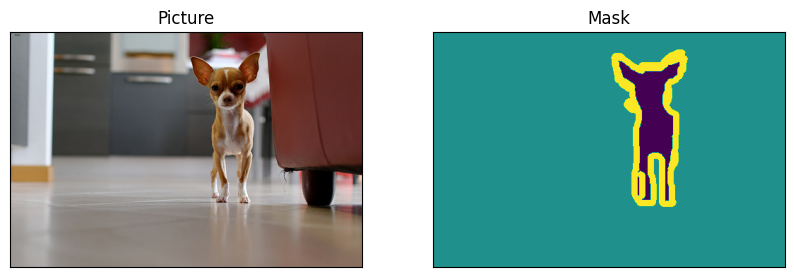

In [5]:
train_dataset = OxfordIIITPet(
    str(files_path/"OxfordIIITPet"),
    target_types = "segmentation",
    download = True
)
test_dataset = OxfordIIITPet(
    str(files_path/"OxfordIIITPet"),
    target_types = "segmentation",
    download = True,
    split = "test"
)

test_picture_index = 500

plt.figure(figsize = (10, 9))
plt.subplot(121)
plt.imshow(train_dataset[test_picture_index][0])
plt.xticks([]);plt.yticks([])
plt.title("Picture")

plt.subplot(122)
plt.imshow(train_dataset[test_picture_index][1])
plt.xticks([]);plt.yticks([])
plt.title("Mask")

plt.show()

### Transfomations

The network does not understand images. So we have to create tensors from images. Here we have added some transformations to our dataset. Let's see what they do.

In [6]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Lambda(lambda x: x.to(DEVICE))
])
target_transfrom = T.Compose([
    T.Resize((256, 256)),
    T.PILToTensor(),
    # Classes are marked starting with 1 but in python it's easier to work with
    # with sets that start with 0, so the following transformation fixes this
    # inconvenience
    T.Lambda(lambda x: (x - 1).long()),
    # PILToTensor returns an image with an extra dimension for channels,
    # but the target has only one channel, so we don't need that extra dimension.
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x.to(DEVICE))
])

transforms = torchvision.datasets.vision.StandardTransform(
    transform, target_transfrom
)

train_dataset.transforms = transforms
test_dataset.transforms = transforms

This is the shape of the tensor used as input to the model - it's regular three channel picture.

In [7]:
train_dataset[test_picture_index][0].shape

torch.Size([3, 256, 256])

This is the shape and unique values that appear in the target. So it's just an array whose shape is the same as the shape of the input images, but it only takes three values.

In [8]:
print("Shape:", list(train_dataset[test_picture_index][1].shape))
print("Values:", list(train_dataset[test_picture_index][1].unique()))

Shape: [256, 256]
Values: [tensor(0), tensor(1), tensor(2)]


### Model fitting


In [9]:
@torch.inference_mode
def evaluate(
    model: UNet,
    loader: DataLoader,
    loss_fun: Callable,
    tqdm_desc: str = None
) -> tuple[float, float]:

    model.eval()

    total_pixels = 0
    correct_pixels = 0
    loss_cumulative = 0

    for X, y in tqdm(loader, desc=tqdm_desc):

        predict = model(X)

        loss_cumulative += loss_fun(input=predict, target=y).item()

        correct_pixels += (predict.argmax(dim=1) == y).sum()
        total_pixels += y.numel()

    return correct_pixels/total_pixels, loss_cumulative/len(loader)

def run_epoch(
    model: UNet,
    loader: DataLoader,
    loss_fun: Callable,
    optimizer: torch.optim.Optimizer
):
    model.train()
    for X, y in tqdm(loader, desc="Fitting"):
        predict = model(X)
        loss_value = loss_fun(input=predict, target=y)
        loss_value.backward()
        optimizer.step()

In [ ]:
torch.manual_seed(20)

model = UNet(n_channels=3, n_classes=3)
model.to(DEVICE)

loss_fun = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer=optimizer,
#     step_size=5,
#     gamma=0.1
# )

try:
    for epoch in range(50):

        run_epoch(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            optimizer=optimizer
        )
        train_accuracy, train_loss = evaluate(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate train"
        )
        test_accuracy, test_loss = evaluate(
            model=model,
            loader=test_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate test"
        )
        # scheduler.step()
        print(f"Train: loss-{train_loss}, accuracy-{train_accuracy}")
        print(f"Test: loss-{test_loss}, accuracy-{test_accuracy}")
except KeyboardInterrupt:
    pass

Fitting:   0%|          | 0/58 [00:00<?, ?it/s]

Save model to the hugging face.

In [13]:
save_model(model=model, model_name="unet_model.pt")

unet_model.pt:   0%|          | 0.00/69.3M [00:00<?, ?B/s]

### Visual benchmark

Formal bemchmark is great but who actually cares what number you scored - let's check on picutres. Everyone will draw their own conclusions about the quality of the model.

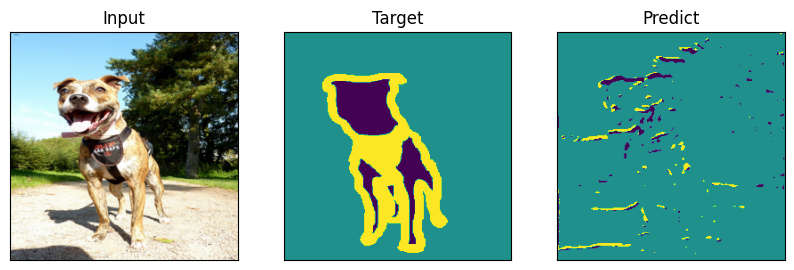

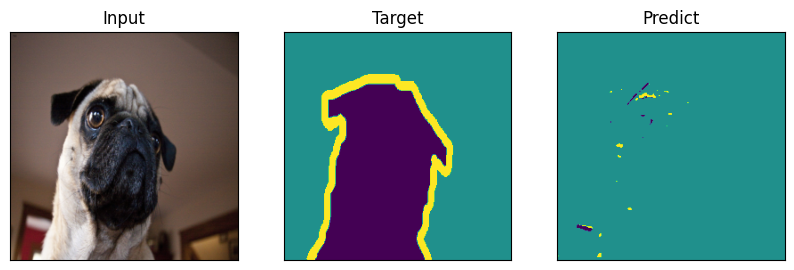

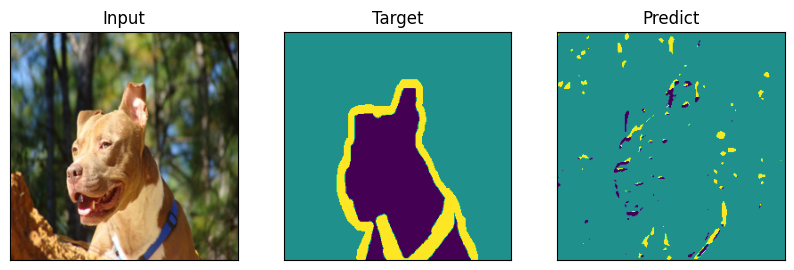

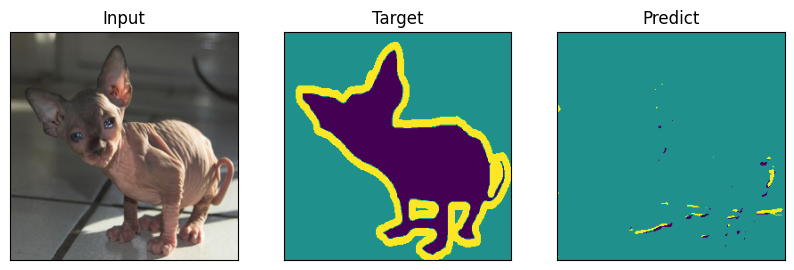

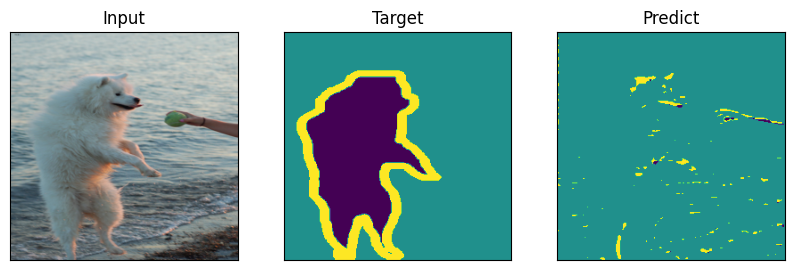

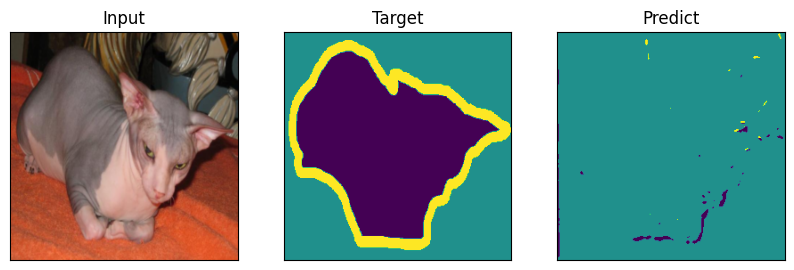

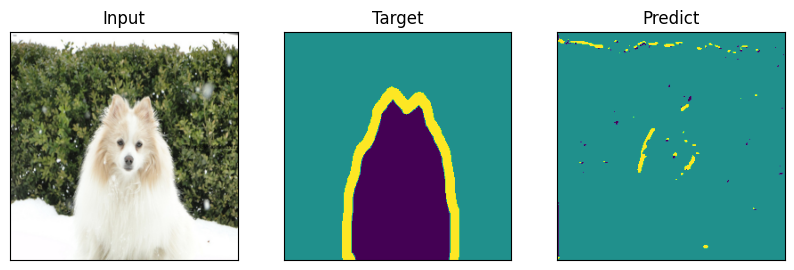

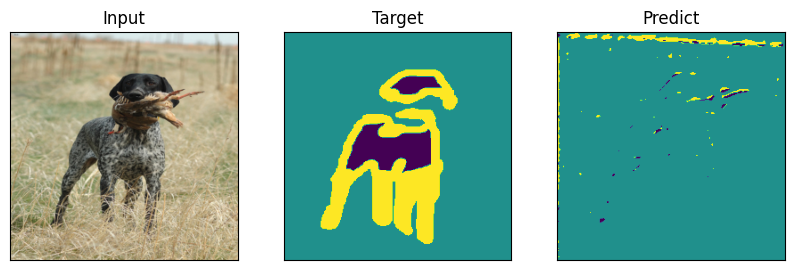

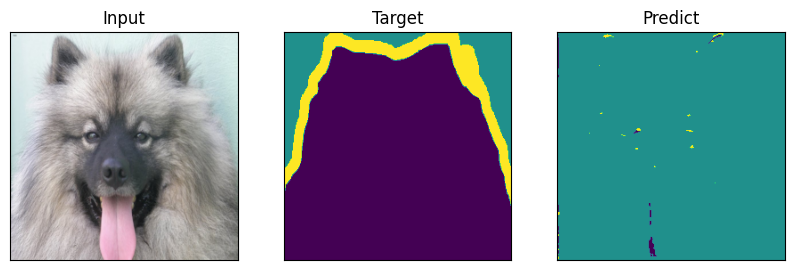

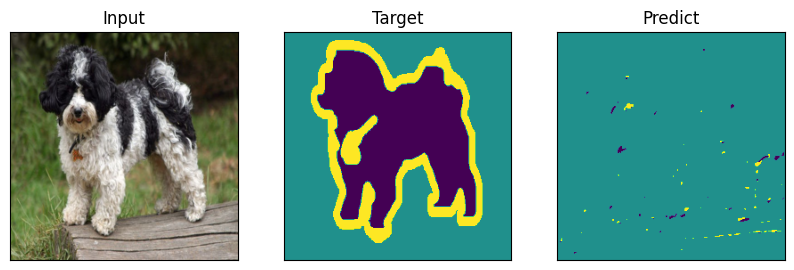

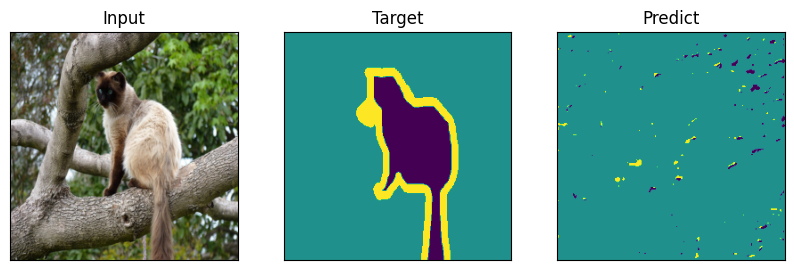

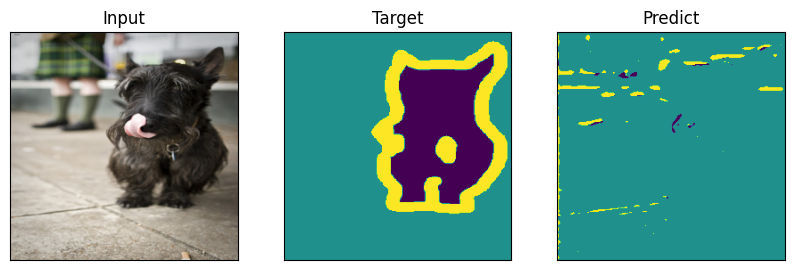

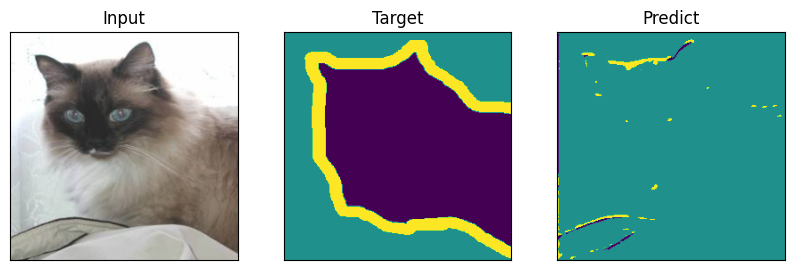

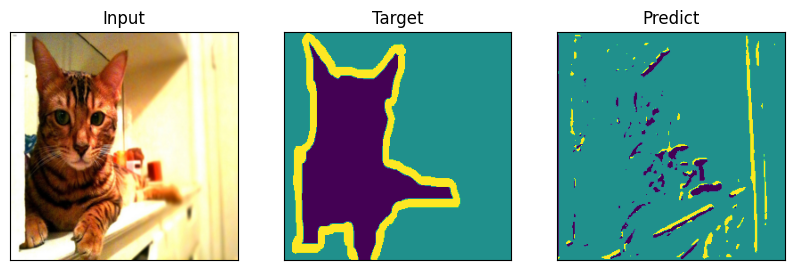

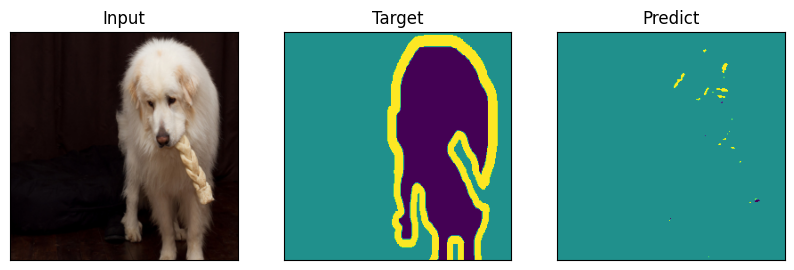

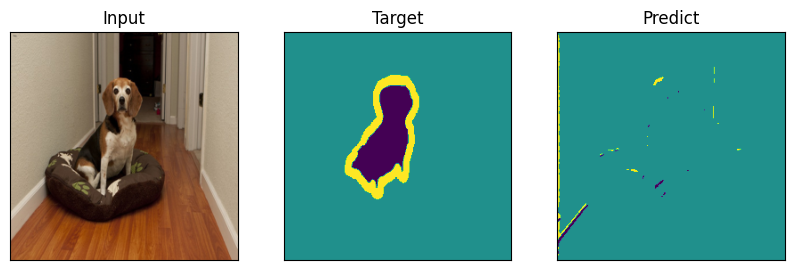

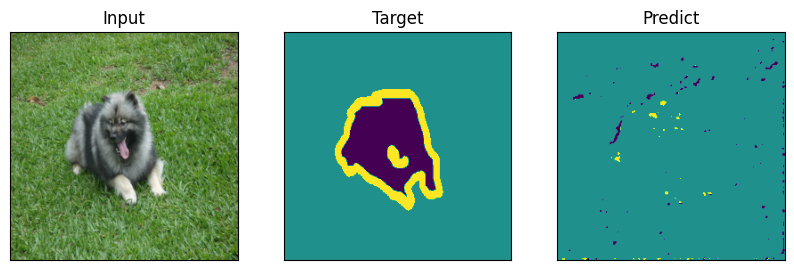

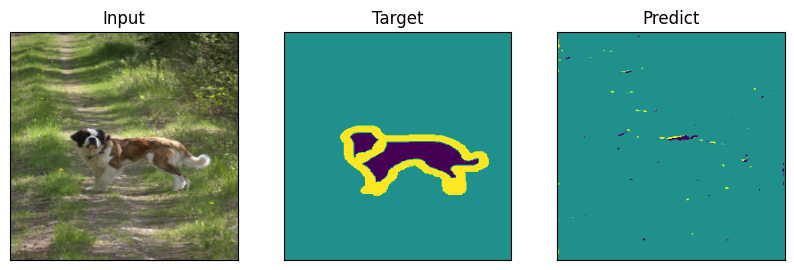

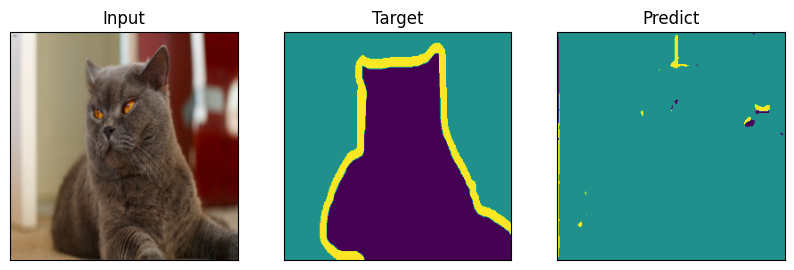

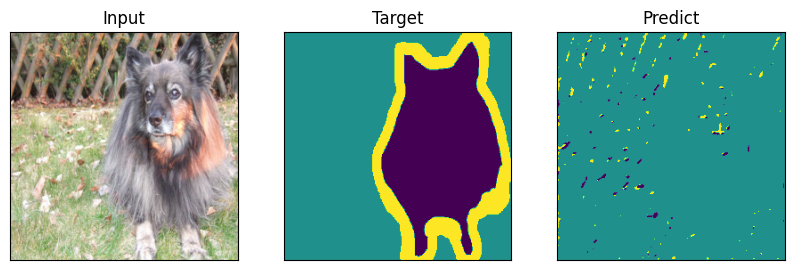

In [19]:
# importing the model
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(
    torch.load("unet_new_architecture.pt")
)
#load_model(model=model, model_name="unet_model.pt")

model = model.eval()

np.random.seed(20)

indx = np.random.randint(0, len(test_dataset), 20)

inputs = torch.stack([test_dataset[i][0] for i in indx])
targets = torch.stack([test_dataset[i][1] for i in indx]).to(torch.uint8)
predicts = model(inputs).max(dim = 1)[1].to(torch.uint8)

def plot_result(model_input, target, predict):
    plt.figure(figsize = (10, 9))

    plt.subplot(131)
    plt.title("Input")
    plt.imshow(T.ToPILImage()(model_input))
    plt.xticks([]);plt.yticks([])

    plt.subplot(132)
    plt.title("Target")
    plt.imshow(T.ToPILImage()(target))
    plt.xticks([]);plt.yticks([])

    plt.subplot(133)
    plt.title("Predict")
    plt.imshow(T.ToPILImage()(predict))
    plt.xticks([]);plt.yticks([])

    plt.show()

for i in range(len(indx)):
    plot_result(inputs[i], targets[i], predicts[i])